---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---

# Using Slurm

## Introduction

This chapter describes how to generate a `spotpython` configuration on a local machine and run the `spotpython` code on a remote machine using Slurm.
We recommend using a jupyter notebook (`*.ipynb`) or a Quarto document (`*.qmd`) on the local machine to generate the configuration and analyze the results.

## Packages important for this Chapter

In [1]:
#| label: packages
import argparse
import pickle
from math import inf
import torch
from spotpython.utils.file import load_result, load_and_run_spot_python_experiment
from spotpython.data.manydataset import ManyToManyDataset
from spotpython.data.diabetes import Diabetes
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.spot import Spot
from spotpython.hyperparameters.values import set_hyperparameter, get_tuned_architecture
from torch.utils.data import TensorDataset
from spotpython.utils.eda import print_res_table

Seed set to 123


## Prepare the Slurm Scripts for Runs on the Remote Machine

Two scripts are required to run the `spotpython` code on the remote machine: 

* `startSlurm.sh` and 
* `startPython.py`.

They should be saved in the same directory on the remote machine as the pickle-configuration (`pkl`) file.
These two scripts must be generated only once and can be reused for different configurations.
For convenience, the scripts are available as templates here:

* [startSlurm.sh](https://github.com/sequential-parameter-optimization/Hyperparameter-Tuning-Cookbook/blob/main/startSlurm.sh)
* [startPython.py](https://github.com/sequential-parameter-optimization/Hyperparameter-Tuning-Cookbook/blob/main/startPython.py)

The `startSlurm.sh` script is a shell script that contains the following code:

In [ ]:
#| label: start
#| eval: false

#!/bin/bash
 
### Vergabe von Ressourcen
#SBATCH --job-name=Test
#SBATCH --account=Accountname/Projektname  # Hier den gewünschten Account angeben
#SBATCH --cpus-per-task=20
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH --error=job.%J.err
#SBATCH --output=job.%J.out
#----
#SBATCH --partition=gpu

if [ -z "$1" ]; then
    echo "Usage: $0 <path_to_spot.pkl>"
    exit 1
fi

SPOT_PKL=$1

module load conda

### change to your conda environment with spotpython installed via
### pip install spotpython
conda activate spot312

python startPython.py "$SPOT_PKL"

exit

Save the code in a file named `startSlurm.sh` and copy the file to the remote machine via `scp`, i.e., 

In [ ]:
#| label: copy-startSlurm-to-remote
#| eval: false
scp startSlurm.sh user@144.33.22.1:

The `startPython.py` script is a Python script that contains the following code:

In [ ]:
#| label: startPython
#| eval: false
import argparse
import pickle
from spotpython.utils.file import load_and_run_spot_python_experiment
from spotpython.data.manydataset import ManyToManyDataset

# Uncomment the following if you want to use a custom model (python source code)
# import sys
# sys.path.insert(0, './userModel')
# import my_regressor
# import my_hyper_dict


def main(pickle_file):
    spot_tuner = load_and_run_spot_python_experiment(filename=pickle_file)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Process a pickle file.')
    parser.add_argument('pickle_file', type=str, help='The path to the pickle file to be processed.')

    args = parser.parse_args()
    main(args.pickle_file)

Save the code in a file named `startPython.py` and copy the file to the remote machine via `scp`, i.e., 

In [ ]:
#| label: copy-startPython-to-remote
#| eval: false
scp startPython.py user@144.33.22.1:

## Generate a `spotpython` Configuration

The configuration can be generated on a local machine using the following command:

In [2]:
#| label: generate-spotpython-config
#| eval: false
# generate data
num_samples = 10_000
input_dim = 10
X = torch.randn(num_samples, input_dim)  # random data for example
Y = torch.randn(num_samples, 1)  # random target for example
data_set = TensorDataset(X, Y)

PREFIX="a06"


fun_control = fun_control_init(
    accelerator="gpu",
    devices="auto",
    num_nodes=1,
    num_workers=19,
    precision="32",
    strategy="auto",
    save_experiment=True,
    PREFIX=PREFIX,
    fun_evals=10,
    max_time=inf,
    data_set = data_set,
    core_model_name="light.regression.NNLinearRegressor",
    hyperdict=LightHyperDict,
    _L_in=input_dim,
    _L_out=1)

fun = HyperLight().fun

set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "l1", [2,3])
set_hyperparameter(fun_control, "epochs", [2,3])
set_hyperparameter(fun_control, "batch_size", [2,5])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2,4])

design_control = design_control_init(init_size=5)

S = Spot(fun=fun,fun_control=fun_control, design_control=design_control)

Seed set to 123


module_name: light
submodule_name: regression
model_name: NNLinearRegressor
Experiment saved to a06_exp.pkl


The configuration is saved as  a pickle-file that contains the full information. In our example, the filename is `a06_exp.pkl`.

::: {.callout-warning}
### Note on `save_experiment`

The `fun_control` dictionary must be initialized with `save_experiment=True` to save the experiment/design configuration.

:::


## Copy the Configuration to the Remote Machine

You can copy the configuration to the remote machine using the `scp` command. The following command copies the configuration to the remote machine `144.33.22.1`:

In [ ]:
#| label: copy-config-to-remote
#| eval: false
scp a06_exp.pkl user@144.33.22.1:

## Run the `spotpython` Code on the Remote Machine

Login on the remote machine and run the following command to start the `spotpython` code:

In [ ]:
#| label: run-spotpython-on-remote
#| eval: false
ssh user@144.33.22.1
# change this to your conda environment!
conda activate spot312 
sbatch ./startSlurm.sh a06_exp.pkl

## Copy the Results to the Local Machine

After the `spotpython` code has finished, you can copy the results back to the local machine using the `scp` command.
The following command copies the results to the local machine:

In [ ]:
#| label: copy-results-to-local
#| eval: false
scp user@144.33.22.1:a06_res.pkl .

::: {.callout-note}
### Experiment and Result Files
* `spotpython` generates two files: 
  * `PREFIX_exp.pkl` (experiment file), which stores the information about running the experiment, and
  * `PREFIX_res.pkl` (result file), which stores the results of the experiment.
:::


## Analyze the Results on the Local Machine

The file `a06_res.pkl` contains the results of the `spotpython` code. You can analyze the results on the local machine using the following code. Note: `PREFIX` is the same as in the previous steps, i.e., `"a06"`.


In [3]:
#| label: spotgui
#| eval: false
PREFIX="a06"
spot_tuner = load_result(PREFIX)

Loaded experiment from a06_res.pkl


In [5]:
spot_tuner.surrogate.get_params()["n_theta"]

10

In [9]:
for param, value in spot_tuner.surrogate.get_params(deep=True).items():
    print(f"{param} -> {value}")

Lambda -> [-2.19275318]
counter -> 4
eps -> 1.4901161193847656e-08
isotropic -> False
log_level -> 50
max_Lambda -> 0
max_p -> 2.0
max_theta -> 2.0
method -> regression
metric_factorial -> canberra
min_Lambda -> -9
min_p -> 1.0
min_theta -> -3.0
model_fun_evals -> 10000
model_optimizer -> <function differential_evolution at 0x13a470860>
n_p -> 1
n_theta -> 10
name -> Kriging
optim_p -> False
p_val -> 2.0
penalty -> 10000.0
seed -> 124
spot_writer -> None
theta -> [ 1.61747997 -3.         -3.         -3.         -3.         -2.8110458
 -3.         -1.33758107  0.00588512 -3.        ]
theta_init_zero -> False
var_type -> ['int', 'int', 'int', 'factor', 'factor', 'float', 'float', 'int', 'factor', 'factor']


### Visualizing the Tuning Progress

Now the `spot_tuner` object is loaded and you can analyze the results interactively.

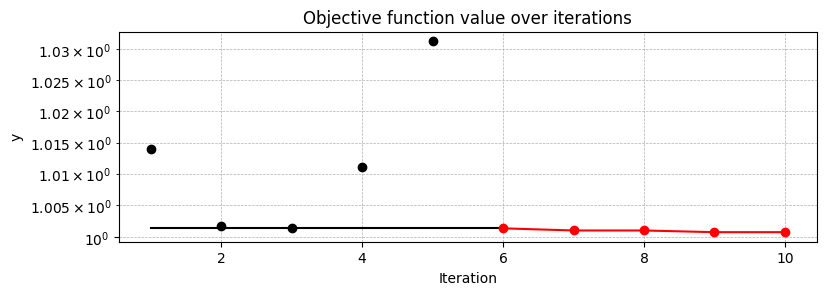

In [10]:
#| label: analyze-results-progress-plot
#| eval: false
spot_tuner.plot_progress(log_y=True, filename=None)

### Design Table with Default and Tuned Hyperparameters

In [11]:
#| label: analyze-results-design-table
#| eval: false
print_res_table(spot_tuner)

| name           | type   | default   |   lower |   upper | tuned             | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|-------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     2.0 |     3.0 | 3.0               | transform_power_2_int |       100.00 | ***     |
| epochs         | int    | 4         |     2.0 |     3.0 | 2.0               | transform_power_2_int |         0.00 |         |
| batch_size     | int    | 4         |     2.0 |     5.0 | 2.0               | transform_power_2_int |         0.00 |         |
| act_fn         | factor | ReLU      |     0.0 |     5.0 | Swish             | None                  |         0.00 |         |
| optimizer      | factor | SGD       |     0.0 |     2.0 | Adadelta          | None                  |         0.00 |         |
| dropout_prob   | float  | 0.01      |     0.0 |   0.025 | 0.0               | None             

### Plotting Important Hyperparameters

l1:  100.0
epochs:  0.0024127928149909827
batch_size:  0.0024127928149909827
act_fn:  0.0024127928149909827
optimizer:  0.0024127928149909827
dropout_prob:  0.0037279856216470473
lr_mult:  0.0024127928149909827
patience:  0.11090189326609365
batch_norm:  2.4457110568364997
initialization:  0.0024127928149909827


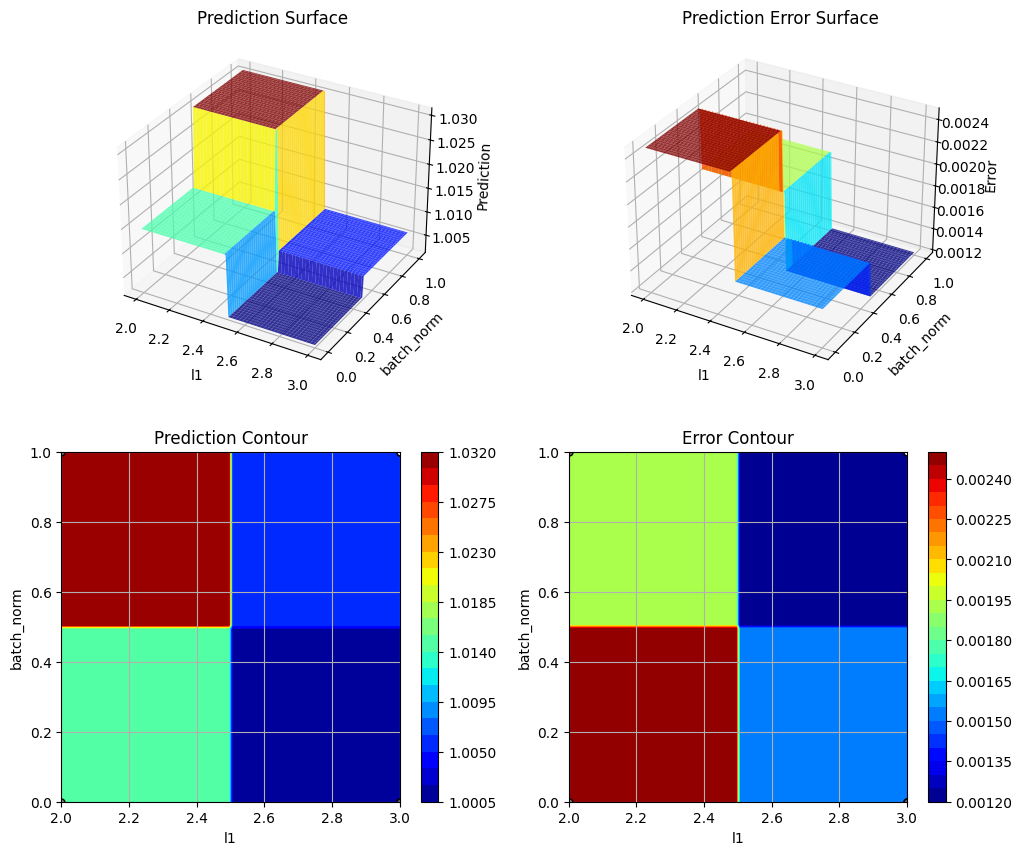

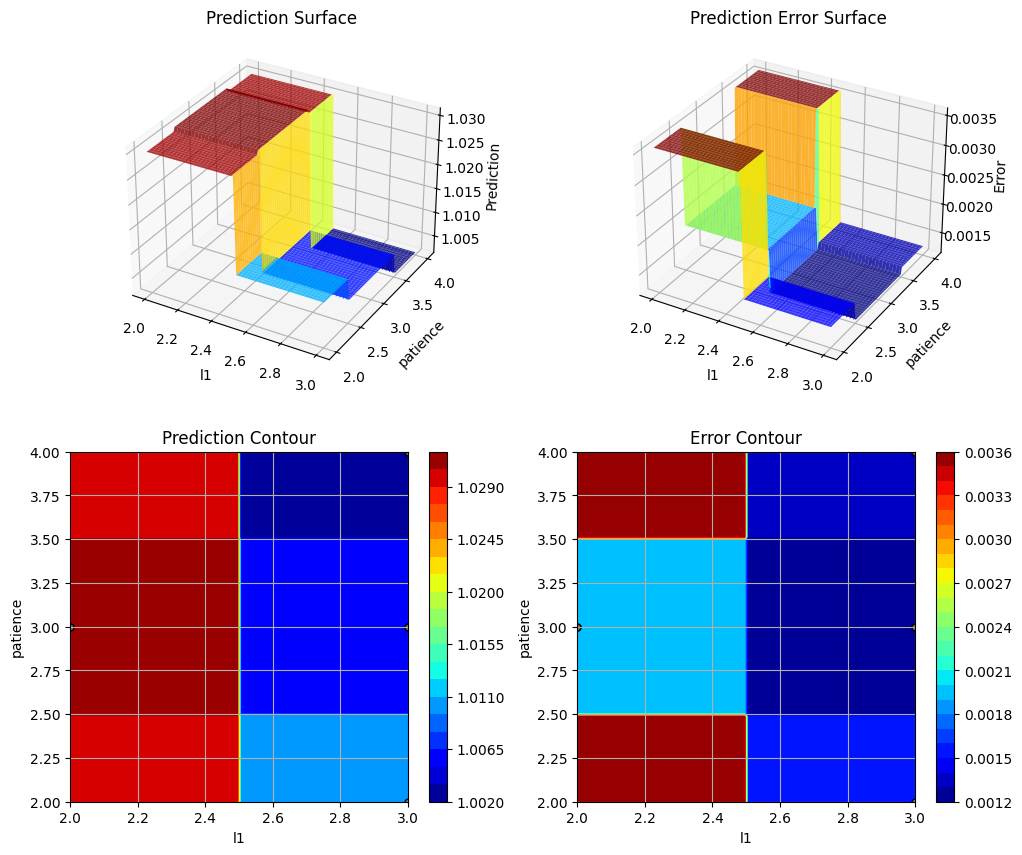

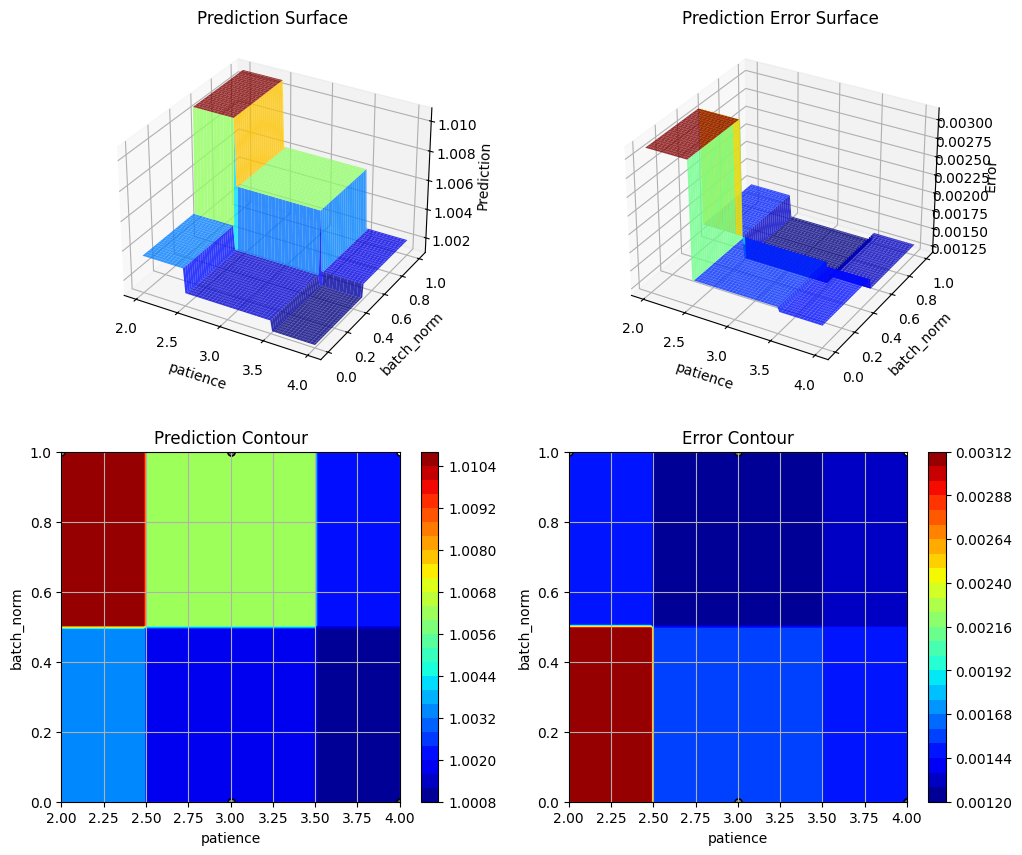

In [12]:
#| label: analyze-results-plot-imp-hyperparam
#| eval: false
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

### The Tuned Hyperparameters

In [13]:
#| label: get_tuned_hyperparameters
#| eval: false
get_tuned_architecture(spot_tuner)

{'l1': 8,
 'epochs': 4,
 'batch_size': 4,
 'act_fn': Swish(),
 'optimizer': 'Adadelta',
 'dropout_prob': 0.0,
 'lr_mult': 4.022563367690831,
 'patience': 16,
 'batch_norm': True,
 'initialization': 'kaiming_uniform'}

## Slurm Command Reference

@tbl-slurm-commands summarizes commands used to manage jobs on a remote machine using Slurm.

| Command | Description |
| :---------|:-------------|
| `sbatch startSlurm.sh a06_exp.pkl` | Submit a job to the Slurm scheduler. The job will run the `startSlurm.sh` script with the argument `a06_exp.pkl`. |
| `squeue -u username` | Check the status of your jobs in the queue. Replace `username` with your actual username. |
| `scancel job_id` | Cancel a job. Replace `job_id` with the actual job ID you want to cancel. |
| `ssh user@remote_host` | Log in to a remote machine. Replace `user` with your username and `remote_host` with the hostname or IP address of the remote machine. |
| `scp source_file user@remote_host:destination_path` | Copy a file to a remote machine. Replace `source_file` with the path to the file you want to copy, `user` with your username, `remote_host` with the hostname or IP address of the remote machine, and `destination_path` with the path where you want to copy the file on the remote machine. |
| `module load conda` | Load the Conda module on the remote machine. This command may vary depending on the system configuration. |
| `conda activate env_name` | Activate a Conda environment. Replace `env_name` with the name of your Conda environment. |
: Slurm and related commands {#tbl-slurm-commands}


## Jupyter Notebook

:::{.callout-note}

* The Jupyter-Notebook of this lecture is available on GitHub in the [Hyperparameter-Tuning-Cookbook Repository](https://github.com/sequential-parameter-optimization/Hyperparameter-Tuning-Cookbook/blob/main/a_06_slurm.ipynb)

:::
